In [ ]:
# mount on google drive
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/satellite-altimetry-course')


In [ ]:
# !pip install cartopy
# !pip install pyrsimg
# !apt-get install hdf5-tools


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 17.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  hdf5-tools
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 347 kB of archives.
After this operation, 1,255 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 hdf5-tools amd64 1.10.7+repack-4ubuntu2 [347 kB]
Fetched 347 kB in 4s (78.7 kB/s)
Selecting previously unselected package hdf5-tools.
(Reading database ... 121913 files and directories currently installed.)
Preparing to unpack .../hdf5-tools_1.10.7+repack-4ubuntu2_amd64.deb ...
Unpacking hdf5-tools (1.10.7+repack-4ubuntu2) ...
Setting up hdf5-tools (1.10.7+repack-4ubuntu2) ...
Processing triggers for man-db (2.10.2-1) ...


### **ICESat-2数据处理**

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
from shapely.geometry import Point
from pyrsimg import readTiff, imgShow, geo2imagexy


In [ ]:
path_atl06 = 'data/laser/isat2_gla_region.h5'
path_rsimg = 'data/rsimg/s2_gla_region_20220707.tif'
path_dem = 'data/srtm/SRTMGL1Ellip_gla_region.tif'
path_gla_vec = 'data/laser/gla_region.gpkg'


In [ ]:
!h5ls $path_atl06
# !h5ls $path_atl06/gt1l/land_ice_segments
# !h5ls $path_atl06/orbit_info


cycle                    Dataset {SCALAR}
elev_gt1l                Dataset {1114}
elev_gt1r                Dataset {505}
elev_gt2l                Dataset {749}
elev_gt2r                Dataset {450}
elev_gt3l                Dataset {911}
elev_gt3r                Dataset {540}
lat_gt1l                 Dataset {1114}
lat_gt1r                 Dataset {505}
lat_gt2l                 Dataset {749}
lat_gt2r                 Dataset {450}
lat_gt3l                 Dataset {911}
lat_gt3r                 Dataset {540}
lon_gt1l                 Dataset {1114}
lon_gt1r                 Dataset {505}
lon_gt2l                 Dataset {749}
lon_gt2r                 Dataset {450}
lon_gt3l                 Dataset {911}
lon_gt3r                 Dataset {540}
orient                   Dataset {SCALAR}
time_delta_gt1l          Dataset {1114}
time_delta_gt1r          Dataset {505}
time_delta_gt2l          Dataset {749}
time_delta_gt2r          Dataset {450}
time_delta_gt3l          Dataset {911}
time_delta_gt3r

In [ ]:
vars_atl06 = {'lat':[], 'lon':[], 'time_dyr':[], 'elev':[]}
beams = ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']
with h5py.File(path_atl06,'r') as gla_atl06:
    for beam in beams:
        vars_atl06['lat'] += list(gla_atl06['lat_'+beam][:])
        vars_atl06['lon'] += list(gla_atl06['lon_'+beam][:])
        vars_atl06['time_dyr'] += list(gla_atl06['time_dyr_'+beam][:])
        vars_atl06['elev'] += list(gla_atl06['elev_'+beam][:])
    vars_atl06['lat'] = np.array(vars_atl06['lat'])
    vars_atl06['lon'] = np.array(vars_atl06['lon'])
    vars_atl06['time_dyr'] = np.array(vars_atl06['time_dyr'])
    vars_atl06['elev'] = np.array(vars_atl06['elev'])
    print(vars_atl06['lat'].shape)

## 2. remote sensing image
rsimg = readTiff(path_rsimg)
## 3. dem image
dem = readTiff(path_dem)
## 4. glacier region
gla_vec = gpd.read_file(path_gla_vec)


(4269,)


<Axes: >

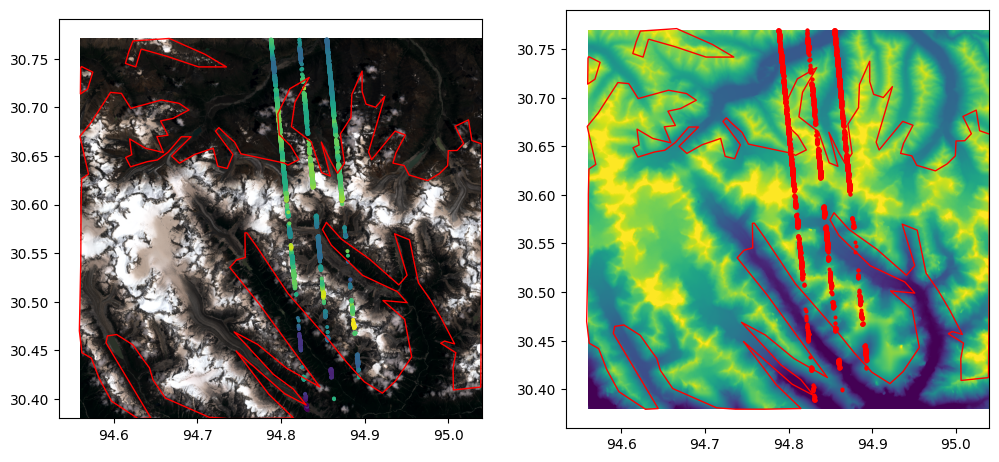

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))
imgShow(rsimg.array, extent=rsimg.geoextent, per_band_clip=10, ax=ax[0])
ax[0].scatter(x=vars_atl06['lon'], y=vars_atl06['lat'], c=vars_atl06['elev'], s=3.5)
imgShow(dem.array, extent=dem.geoextent, ax=ax[1])
ax[1].scatter(x=vars_atl06['lon'], y=vars_atl06['lat'], c='red', s=3.5)
gla_vec.plot(ax=ax[0], facecolor="none", edgecolor='red')
gla_vec.plot(ax=ax[1], facecolor="none", edgecolor='red')


In [ ]:
## 筛选出冰川点
ids_gla = np.zeros(shape=(vars_atl06['lon'].shape))
for i, lon in enumerate(vars_atl06['lon']):
    point = Point(lon, vars_atl06['lat'][i])
    if gla_vec.geometry[0].contains(point):
        ids_gla[i]=1
ids_gla


array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
row, col = geo2imagexy(x=vars_atl06['lon'], \
                         y=vars_atl06['lat'], \
                         gdal_trans=dem.geotrans, \
                         integer=True)
dem_isat_fp = dem.array[row, col]
dem_isat_fp[90:100]


array([3419.73852539, 3421.73901367, 3422.74169922, 3425.7421875 ,
       3764.7512207 , 3884.75488281, 3884.75488281, 4015.75805664,
       4038.77197266, 5187.82714844])

Text(0.5, 1.0, 'measurements on non-glacier region')

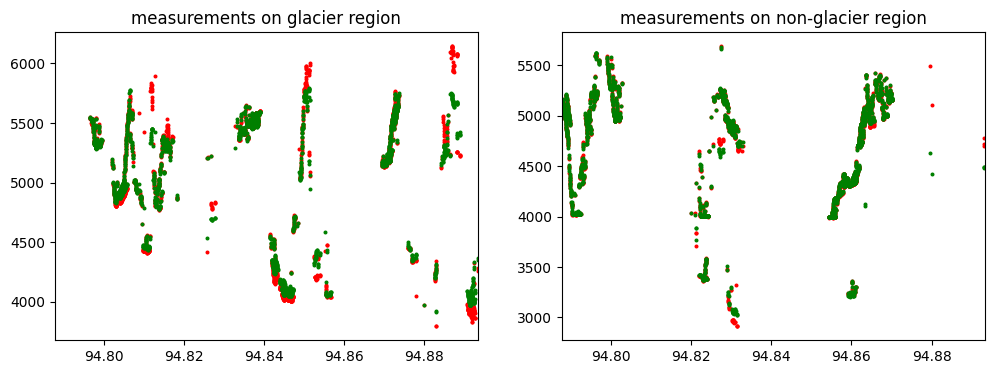

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
### glacier region
ax[0].scatter(x=vars_atl06['lon'][ids_gla==1], y=vars_atl06['elev'][ids_gla==1], c='red', s=3.5)  ## icesat data
ax[0].scatter(x=vars_atl06['lon'][ids_gla==1], y=dem_isat_fp[ids_gla==1], c='green', s=3.5)  ## srtm data
ax[0].set_xlim(min(vars_atl06['lon']), max(vars_atl06['lon']))
ax[0].set_title('measurements on glacier region')
### non-glacier region
ax[1].scatter(x=vars_atl06['lon'][ids_gla==0], y=vars_atl06['elev'][ids_gla==0], c='red', s=3.5)  ## icesat data
ax[1].scatter(x=vars_atl06['lon'][ids_gla==0], y=dem_isat_fp[ids_gla==0], c='green', s=3.5)  ## srtm data
ax[1].set_xlim(min(vars_atl06['lon']), max(vars_atl06['lon']))
ax[1].set_title('measurements on non-glacier region')


### 冰川高程变化计算

In [ ]:
## 冰川区域icesat-2观测值与dem高程值间差值
dif_ele = vars_atl06['elev'] - dem_isat_fp
ids_gla_thre = np.where((ids_gla==1) & (abs(dif_ele)<150))   ## glacier region and elevation change < 150
dif_ele_gla = dif_ele[ids_gla_thre]
print(dif_ele_gla.mean())
## 非冰川区域icesat-2观测值与dem高程值间差值
ids_stable_thre = np.where((ids_gla==0) & (abs(dif_ele)<50)) ## non-glacier region and elevation change < 50
dif_ele_stable = dif_ele[ids_stable_thre]
print(dif_ele_stable.mean())


-13.536416397822064
-3.38964902325006


In [ ]:
## 冰川高程变化改正
dif_ele_gla_cor = dif_ele_gla.mean()-dif_ele_stable.mean()
dif_ele_gla_cor


-10.146767374572004

### 冰川高程变化率计算

In [ ]:
gla_ele_change_rate = dif_ele_gla_cor/(vars_atl06['time_dyr'][0]-2000)  ## srtm time is 2000/2/11
print(gla_ele_change_rate)


-0.4926617462155448


### 联合icesat观测结果进行分析

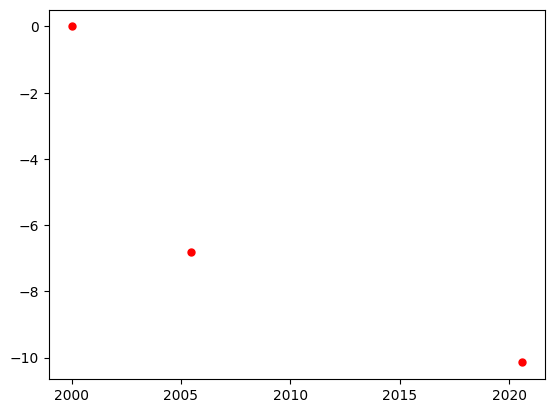

In [ ]:
time = [2000, 2005.46, vars_atl06['time_dyr'][0]]
ele_dif = [0, -6.799, dif_ele_gla_cor]
plt.plot(time, ele_dif, '.r', markersize=10)



In [ ]:
### 观测值标准差估算
sigma = np.std(dif_ele_stable)
print(sigma)


8.678281100566405


### 不同高程区间冰川消融速率分析

In [ ]:
### icesat-2冰川区域高程观测值
# ele_gla_isa2 = vars_atl06['elev'][ids_gla==1]
# ele_gla_dem = dem_isat_fp[ids_gla==1]
# ele_gla_isa2


In [ ]:
ele_bin_1 = [4000, 4500]
ele_bin_2 = [5000, 5500]
ele_gla_isat2 = vars_atl06['elev'][ids_gla_thre]

### elevation bin 1
ids_ele_bin_1 = np.where((ele_gla_isat2>ele_bin_1[0]) & (ele_gla_isat2<ele_bin_1[1]))
dif_ele_gla_bin1 = dif_ele_gla[ids_ele_bin_1]
mean_dif_ele_bin1 = dif_ele_gla_bin1.mean()
print(mean_dif_ele_bin1)

### elevation bin 2
ids_ele_bin_2 = np.where((ele_gla_isat2>ele_bin_2[0]) & (ele_gla_isat2<ele_bin_2[1]))
dif_ele_gla_bin2 = dif_ele_gla[ids_ele_bin_2]
mean_dif_ele_bin2 = dif_ele_gla_bin2.mean()
print(mean_dif_ele_bin2)



-33.60923200334821
0.8290919126729249
